## Regressão simbólica aplicada ao modelo populacional de Verhulst

In [1]:
# Imports de bibliotecas e funções

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import verhulst, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(verhulst, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

In [3]:
# Constantes relacionadas a busca

NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

pset.addEphemeralConstant("rand103", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                fitness                	                  size                 
   	      	---------------------------------------	---------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg  	gen	min	nevals	std    
0  	1000  	42.9907	0  	1.52645	1000  	464.573	3.893	0  	2  	1000  	1.65032
1  	513   	15.0265	1  	1.52645	513   	17.5997	3.782	1  	1  	513   	1.65423
2  	516   	12.7231	2  	1.52645	516   	14.9731	3.723	2  	1  	516   	1.60757
3  	542   	11.5385	3  	1.52645	542   	15.2349	4.008	3  	1  	542   	1.59121
4  	484   	10.6775	4  	1.52645	484   	18.9336	4.287	4  	1  	484   	1.59644
5  	522   	9.65806	5  	1.52645	522   	16.9189	4.422	5  	1  	522   	1.56266


C:\JupyterLab\meu-jupyter-ilum\3 semestre\Redes Neurais\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_10076/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))
c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


6  	519   	inf    	6  	1.52645	519   	nan    	4.579	6  	1  	519   	1.64309
7  	481   	7.52618	7  	1.52645	481   	11.6685	4.646	7  	1  	481   	1.46379
8  	498   	1.98774e+40	8  	1.52645	498   	4.44034e+41	4.68 	8  	1  	498   	1.55293
9  	486   	9.98842e+39	9  	1.52645	486   	3.15704e+41	4.676	9  	1  	486   	1.48695
10 	503   	9.98842e+39	10 	1.52645	503   	3.15704e+41	4.552	10 	1  	503   	1.43781
11 	501   	1592.47    	11 	1.52645	501   	50163.3    	4.466	11 	1  	501   	1.48487
12 	516   	5.32274e+40	12 	1.52645	516   	1.18901e+42	4.468	12 	1  	516   	1.46594
13 	547   	inf        	13 	1.52645	547   	nan        	4.368	13 	1  	547   	1.38585
14 	471   	2.66137e+40	14 	1.52645	471   	8.41178e+41	4.384	14 	1  	471   	1.36182
15 	506   	7.79609    	15 	1.52645	506   	59.7973    	4.413	15 	1  	506   	1.44791
16 	510   	1926.41    	16 	1.52645	510   	60730.1    	4.413	16 	2  	510   	1.53702
17 	492   	inf        	17 	1.52645	492   	nan        	4.354	17 	1  	492   	1.47129
18 	474   	8.3059e+4

In [11]:
for i in hof.items:
    print(str(i))
    print()

Exp(Exp(add(mul(Div(t, sub(-1, t)), t), neg(t))))

Exp(Exp(add(neg(t), mul(add(-1, t), mul(t, t)))))

Exp(Exp(add(mul(t, mul(add(t, -1), t)), neg(t))))

Exp(Exp(add(mul(add(t, -1), mul(t, t)), neg(t))))

Exp(Exp(add(mul(add(-1, t), mul(t, t)), neg(t))))



### Reportando melhor individuo encontrado 

Exp(Exp(add(mul(Div(t, sub(-1, t)), t), neg(t))))


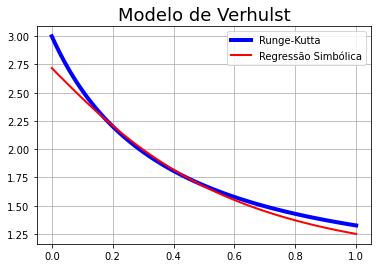

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Verhulst', size = 18)
ax.plot(T, X, label = 'Runge-Kutta', c = 'b', linewidth = 4)
ax.plot(T, Xexpr, label = 'Regressão Simbólica', c = 'r', linewidth = 2)
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Verhulst_1.png', dpi = 200)

In [13]:
# transformando as funções em numéricas 

def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)
    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand104", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
print("O melhor individuo encontrado: ")
display(sp.expand(func(t)))

O melhor individuo encontrado: 


exp(exp(-t)*exp(t**2/(-t - 1)))